In [9]:
# %matplotlib widget


import numpy as np
import matplotlib.pyplot as plt
import scipy
from data_io import read_iq_data
from filters import simple_squelch, decimating_fir_filter, fractional_delay_fir_filter
from visualisation import plot_payload, compare_bits_with_reference, subplots_iq
from receiver import ReceiverBLE, Receiver802154

# Read reference for BER comparison

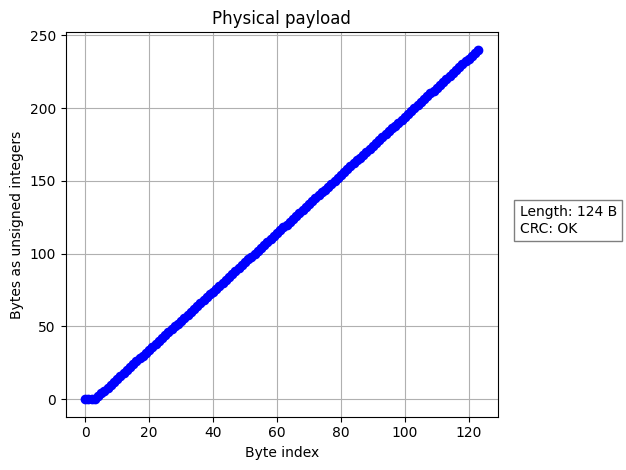

In [10]:
filename: str = "BLE_0dBm.dat"
fs: int | float = 10e6  # Hz
sps = 10
decimation: int = 1
base_address = 0x12345678  # As defined in DotBot radio_default.h

# Open file
iq_samples = read_iq_data(f"../capture_nRF/data/new/{filename}")
iq_samples = decimating_fir_filter(
    iq_samples, decimation=decimation, gain=1, fs=fs, cutoff_freq=1.5e6, transition_width=1000e3, window="hamming"
)
iq_samples = simple_squelch(iq_samples, threshold=10e-2)

# Initialise the receiver and process data
receiver = ReceiverBLE(fs=fs / decimation, sps=sps / decimation)
bit_samples = receiver.demodulate(iq_samples)  # From IQ samples to hard decisions
reference_packet: list[dict] = receiver.process_phy_packet(bit_samples, base_address)  # From hard decisions to packets
reference_packet: dict = reference_packet[0]
plot_payload(reference_packet)
plt.show()

# Read interferenced packet and compare (BER)

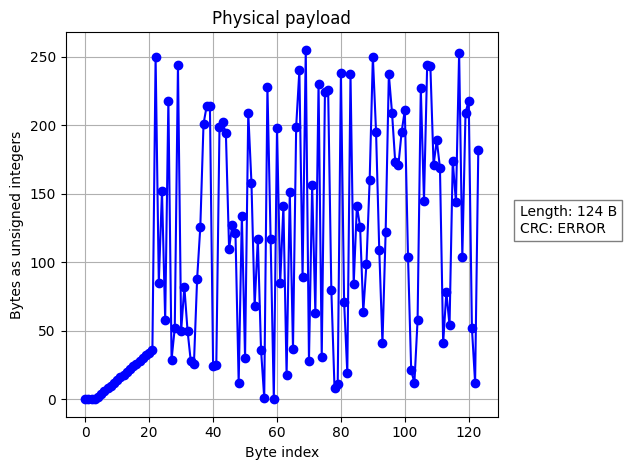

bit_error_rate = 38.41


In [11]:
# filename: str = "BLE_802154_0dBm_8dBm_0MHz.dat"
filename: str = "BLE_tone_0dBm_8dBm_0MHz.dat"

# Open file
iq_samples = read_iq_data(f"../capture_nRF/data/new/{filename}")
iq_samples = decimating_fir_filter(
    iq_samples, decimation=decimation, gain=1, fs=fs, cutoff_freq=1.5e6, transition_width=1000e3, window="hamming"
)
iq_samples = simple_squelch(iq_samples, threshold=10e-2)

# Initialise the receiver and process data
receiver = ReceiverBLE(fs=fs / decimation, sps=sps / decimation)
bit_samples = receiver.demodulate(iq_samples)  # From IQ samples to hard decisions
interfered_packet: list[dict] = receiver.process_phy_packet(bit_samples, base_address)  # From hard decisions to packets
interfered_packet: dict = interfered_packet[0]
plot_payload(interfered_packet)
plt.show()

bit2bit_difference = compare_bits_with_reference(interfered_packet["payload"], reference_packet["payload"])
bit_error_rate = sum(bit2bit_difference) / len(bit2bit_difference) * 100
print(f"{bit_error_rate = :.2f}")

# Read interference and plot it with interfered packet

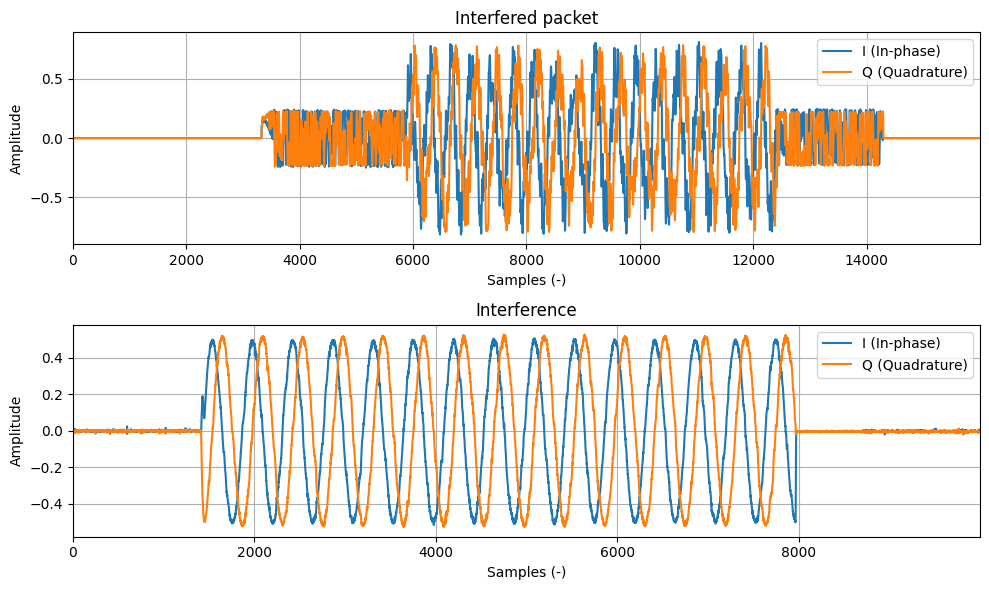

In [12]:
filename: str = "tone_8dBm_0MHz_BLE.dat"
# filename: str = "802154_8dBm_0MHz.dat"

# Open file
iq_samples_interference = read_iq_data(f"../capture_nRF/data/new/{filename}")
subplots_iq([iq_samples, iq_samples_interference], fs, ["Interfered packet", "Interference"])

## Correlate interference with interfered packet

max_idx = 3180


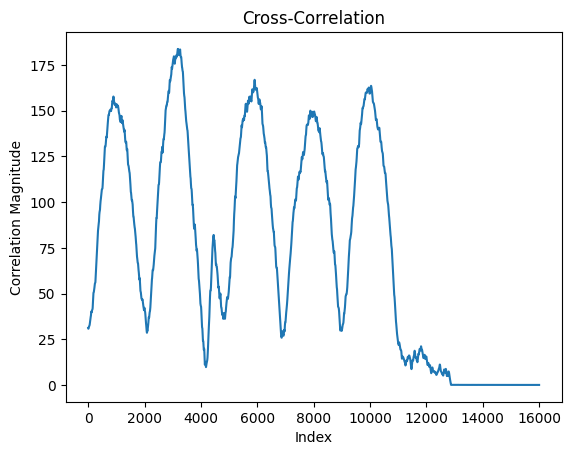

In [13]:
corr = scipy.signal.correlate(iq_samples, iq_samples_interference, mode="full")
max_idx = np.argmax(np.abs(corr))
offset = len(iq_samples_interference) - 1  # Because using mode="full"
max_idx -= offset
print(f"{max_idx = }")

# Plot the correlation for verification
correlation = scipy.signal.correlate(iq_samples, iq_samples_interference, mode="full")[
    offset : offset + len(iq_samples)
]
plt.plot(np.abs(correlation))
# plt.plot(np.imag(correlation))
plt.title("Cross-Correlation")
plt.xlabel("Index")
plt.ylabel("Correlation Magnitude")
plt.show()

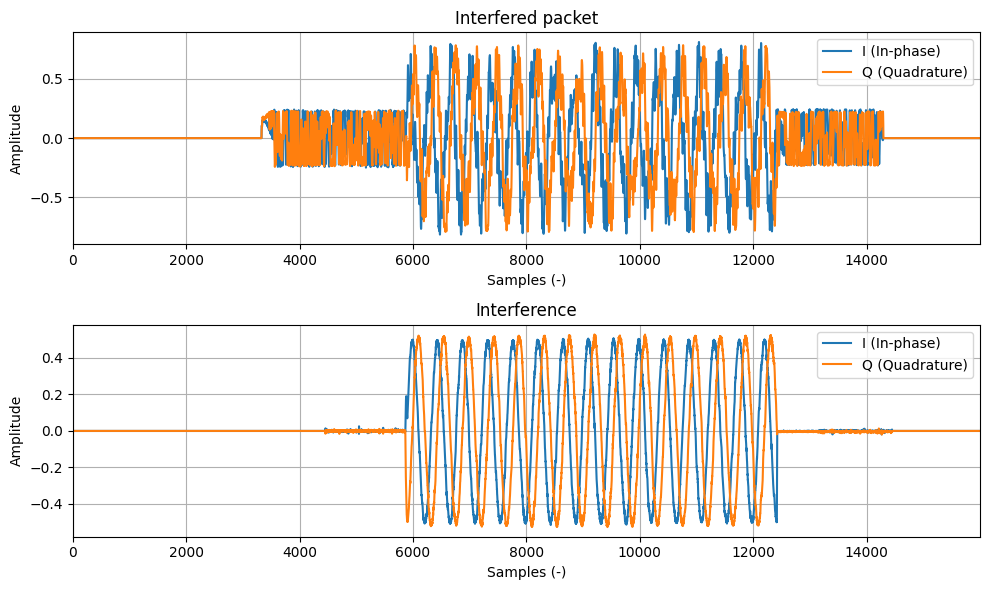

In [14]:
def pad_interference(iq_samples, iq_samples_interference, delay_zero_padding):
    """
    Pads iq_samples_interference with zeros at the beginning (delay_zero_padding)
    and at the end to match the length of iq_samples.
    """
    if delay_zero_padding < 0:
        raise ValueError("delay_zero_padding must be non-negative")

    # Compute the necessary zero padding at the end
    end_padding = len(iq_samples) - (len(iq_samples_interference) + delay_zero_padding)

    if end_padding < 0:
        raise ValueError("The interference plus delay exceeds the length of iq_samples")

    # Construct the padded array
    padded_interference = np.concatenate(
        [
            np.zeros(delay_zero_padding, dtype=iq_samples_interference.dtype),  # Front padding
            iq_samples_interference,  # Interference signal
            np.zeros(end_padding, dtype=iq_samples_interference.dtype),  # End padding
        ]
    )

    return padded_interference


delayed_interference = pad_interference(iq_samples, iq_samples_interference, 4450)
subplots_iq([iq_samples, delayed_interference], fs, ["Interfered packet", "Interference"])

max_idx = 4450
found_phase = 0.5


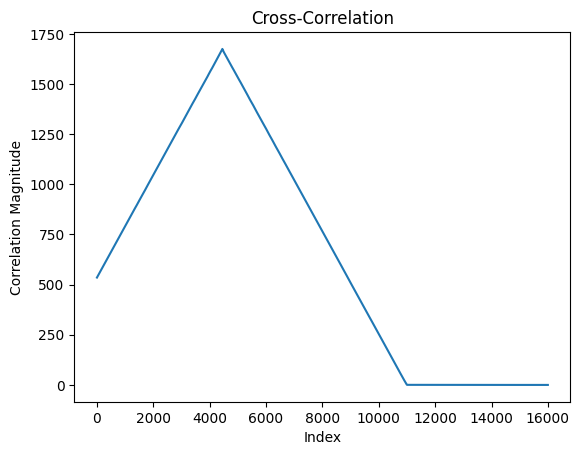

In [15]:
offset = len(iq_samples_interference) - 1  # Because using mode="full"

# Plot the correlation for verification
correlation = scipy.signal.correlate(delayed_interference * np.exp(1j * 0.5), iq_samples_interference, mode="full")[
    offset : offset + len(delayed_interference)
]
max_idx = np.argmax(np.abs(correlation))
found_phase = np.angle(correlation[max_idx])
print(f"{max_idx = }")
print(f"{found_phase = }")

plt.plot(np.abs(correlation))
# plt.plot(np.imag(correlation))
plt.title("Cross-Correlation")
plt.xlabel("Index")
plt.ylabel("Correlation Magnitude")
plt.show()

# Can I demodulate the 15.4 interference from the interfered BLE packet measurement?